In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import mibian as mb
from datetime import datetime, timedelta


In [79]:
stock_symbol = "GOOG"
front_expiry = 0
back_expiry = 1

# Fetch stock data
stock = yf.Ticker(stock_symbol)

# Fetch option chain
front_option_chain = stock.option_chain(stock.options[front_expiry])
calls = front_option_chain.calls
calls["cp"] = "c"
puts = front_option_chain.puts
puts["cp"] = "p"
front_options = pd.concat([calls, puts], axis=0)
back_option_chain = stock.option_chain(stock.options[back_expiry])
calls = back_option_chain.calls
calls["cp"] = "c"
puts = back_option_chain.puts
puts["cp"] = "p"
back_options = pd.concat([calls, puts], axis=0)


In [70]:
from scipy.stats import norm


def black_scholes(
    stock_price, strike, interest_rate, days_to_expiry, implied_volatility, option_type
):
    T = days_to_expiry / 365
    d1 = (
        np.log(stock_price / strike)
        + (interest_rate + 0.5 * implied_volatility**2) * T
    ) / (implied_volatility * np.sqrt(T))
    d2 = d1 - implied_volatility * np.sqrt(T)

    if option_type == "call":
        return stock_price * norm.cdf(d1) - strike * np.exp(
            -interest_rate * T
        ) * norm.cdf(d2)
    elif option_type == "put":
        return strike * np.exp(-interest_rate * T) * norm.cdf(
            -d2
        ) - stock_price * norm.cdf(-d1)


def calculate_greeks(
    stock_price, strike, interest_rate, days_to_expiry, implied_volatility, option_type
):
    T = days_to_expiry / 365
    d1 = (
        np.log(stock_price / strike)
        + (interest_rate + 0.5 * implied_volatility**2) * T
    ) / (implied_volatility * np.sqrt(T))
    d2 = d1 - implied_volatility * np.sqrt(T)

    delta, gamma, theta, vega = None, None, None, None

    if option_type == "call":
        delta = norm.cdf(d1)
        gamma = norm.pdf(d1) / (stock_price * implied_volatility * np.sqrt(T))
        theta = (
            -stock_price * norm.pdf(d1) * implied_volatility / (2 * np.sqrt(T))
            - interest_rate * strike * np.exp(-interest_rate * T) * norm.cdf(d2)
        ) / 365
        vega = stock_price * np.sqrt(T) * norm.pdf(d1) / 100
    elif option_type == "put":
        delta = norm.cdf(d1) - 1
        gamma = norm.pdf(d1) / (stock_price * implied_volatility * np.sqrt(T))
        theta = (
            -stock_price * norm.pdf(d1) * implied_volatility / (2 * np.sqrt(T))
            + interest_rate * strike * np.exp(-interest_rate * T) * norm.cdf(-d2)
        ) / 365
        vega = stock_price * np.sqrt(T) * norm.pdf(d1) / 100

    return delta, gamma, theta, vega


In [85]:
expirations = stock.options
today = datetime.now()
days_to_expiry1 = max((datetime.fromisoformat(expirations[0]) - today).days, 1)
days_to_expiry2 = (datetime.fromisoformat(expirations[1]) - today).days
days_to_expiry1, days_to_expiry2


(1, 7)

In [96]:
def calculate_greeks_and_payoff(option, stock_price, interest_rate, days_to_expiry):
    call_flag = option["contractSymbol"].find("C") >= 0
    option_type = "call" if call_flag else "put"

    delta, gamma, theta, vega = calculate_greeks(
        stock_price,
        option["strike"],
        interest_rate,
        days_to_expiry,
        option["impliedVolatility"],
        option_type,
    )

    payoff = option["lastPrice"] * delta

    return pd.Series(
        {
            "symbol": option["contractSymbol"],
            "strike": option["strike"],
            "payoff": payoff,
            "delta": delta,
            "gamma": gamma,
            "theta": theta,
            "vega": vega,
            "ask": option["ask"],
            "bid": option["bid"],
            "last": option["lastPrice"],
        }
    )


In [97]:
interest_rate = 0.04  # Example interest rate, you can use any appropriate source
refPrice = stock.info["open"]

front_greeks = front_options.apply(
    calculate_greeks_and_payoff,
    axis=1,
    stock_price=refPrice,
    interest_rate=interest_rate,
    days_to_expiry=days_to_expiry1,
).set_index("symbol")
back_greeks = back_options.apply(
    calculate_greeks_and_payoff,
    axis=1,
    stock_price=refPrice,
    interest_rate=interest_rate,
    days_to_expiry=days_to_expiry1,
).set_index("symbol")


In [107]:
front_greeks


,strike,payoff,delta,gamma,theta,vega,ask,bid,last
symbol,,,,,,,,,
GOOG230421C00045000,45.0,60.113583,0.976663,0.001091,-1.398550,0.003022,61.40,60.35,61.55
GOOG230421C00050000,50.0,41.955740,0.932350,0.001997,-4.285802,0.007164,59.85,56.90,45.00
GOOG230421C00055000,55.0,49.695641,0.969860,0.001713,-1.367753,0.003741,51.40,50.35,51.24
GOOG230421C00060000,60.0,45.148096,0.965735,0.002156,-1.343324,0.004159,46.40,45.35,46.75
GOOG230421C00065000,65.0,38.937576,0.960710,0.002745,-1.320449,0.004652,41.40,40.35,40.53
...,...,...,...,...,...,...,...,...,...
GOOG230421P00135000,135.0,-34.826068,-0.774773,0.010101,-4.445122,0.016437,35.05,30.50,44.95
GOOG230421P00140000,140.0,-43.966067,-0.955784,0.005480,-0.781991,0.005119,34.45,30.15,46.00
GOOG230421P00145000,145.0,-27.558208,-0.569384,0.005764,-13.378240,0.021521,56.45,53.70,48.40


In [106]:
back_greeks

,strike,payoff,delta,gamma,theta,vega,ask,bid,last
symbol,,,,,,,,,
GOOG230428C00050000,50.0,56.993251,0.999882,2.143923e-05,-0.010496,2.541051e-05,57.85,53.50,57.00
GOOG230428C00055000,55.0,38.013414,0.999038,1.444475e-04,-0.042532,1.779129e-04,56.15,52.10,38.05
GOOG230428C00060000,60.0,32.973305,0.998586,2.294801e-04,-0.053147,2.532949e-04,51.20,47.10,33.02
GOOG230428C00065000,65.0,26.793800,0.997907,3.682294e-04,-0.066380,3.619363e-04,46.20,42.10,26.85
GOOG230428C00070000,70.0,36.930622,0.999476,1.418437e-04,-0.019826,1.017438e-04,37.70,33.55,36.95
...,...,...,...,...,...,...,...,...,...
GOOG230428P00118000,118.0,-15.223710,-0.998931,8.810059e-04,0.005647,1.960622e-04,13.15,10.10,15.24
GOOG230428P00119000,119.0,-13.488328,-0.999135,6.913946e-04,0.006754,1.613610e-04,14.15,11.15,13.50
GOOG230428P00120000,120.0,-13.697391,-0.999810,1.807032e-04,0.011697,3.965837e-05,14.85,12.30,13.70


<Axes: xlabel='strike'>

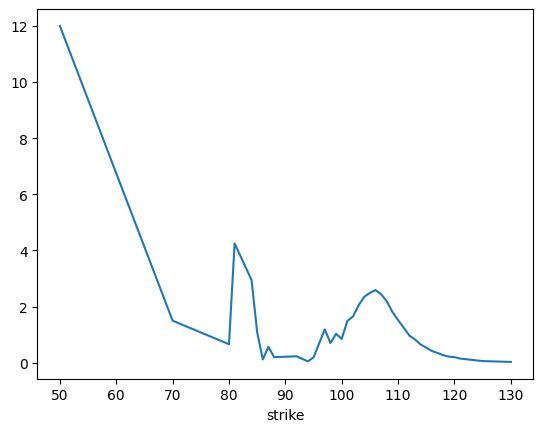

In [121]:
calendar_spreads = front_greeks.copy()
calendar_spreads.index = calendar_spreads.index.str.replace('0421', '0428')

calendar_spreads['spread_price'] = - calendar_spreads['last'] + back_greeks['last']


calls_only = calendar_spreads[calendar_spreads.index.str.contains("C")]
by_strike = calls_only.dropna().set_index("strike")
positive_payoff_only = by_strike[by_strike['spread_price'] > 0]
positive_payoff_only['spread_price'].plot()